In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt
import ratsimulator

### Initialise the square box environment and a virtual rat agent placed in the environment

In [3]:
environment = ratsimulator.Environment.Rectangle(boxsize=(2.2, 2.2), soft_boundary=0.03)
agent = ratsimulator.Agent(environment) # use default walker agent

Singular matrix
Singular matrix


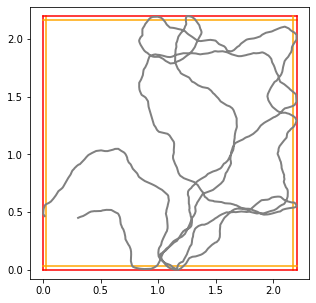

In [4]:
# ----------------------------------
# Try running this cell multiple times to see different trajectories
# ----------------------------------

agent.reset() # reset agent to initial random position and remove any trajectory history
for _ in range(1000):
    agent.step()

# get agent trajectory
velocities = agent.velocities # we don't use this here, but we show it for completeness
positions = agent.positions

# plot the board
fig,ax = plt.subplots(figsize=(5,5))
environment.plot_board(ax)
ax.axis('equal')

# plot the trajectory
ax.plot(*positions.T, color='grey', linewidth=2)

### Initialise Place cells

In [5]:
from PlaceCells import PlaceCells

In [6]:
place_cells = PlaceCells(environment) # default parameters are fine

(positions, place_cell_id) = torch.Size([1001, 512])


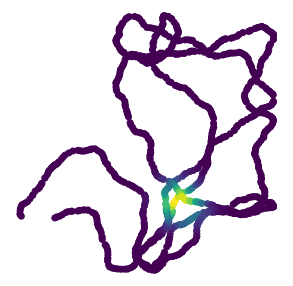

In [7]:
# ----------------------------------
# Show an example place cell activity for the trajectory
# Try increasing trajectory length to see more place cell activity
# ----------------------------------

# get place cell activities for the trajectory.
# PlaceCells assume tensor input, so we convert positions to a tensor
pc_activities = place_cells.softmax_response(torch.tensor(positions))
print("(positions, place_cell_id) =", pc_activities.shape)
# plot an example place cell activity
fig,ax = plt.subplots(figsize=(5,5))
ax.scatter(*positions.T, c=pc_activities[:,0].numpy(), cmap='viridis')
ax.axis('equal')
ax.axis('off');


### Demonstrate the dataloader

In [8]:
from dataloader import Dataset

In [9]:
# set num_samples essentially infinite, since data is generated on the fly anyway
dataset = Dataset(agent, place_cells, num_samples=int(1e+14), seq_len=20)
# you can get example data from the dataset like this:
velocities, init_pc_positions, labels, positions = dataset[0]
print("---> Single example data shapes: <---")
print("velocities =", velocities.shape)
print("init_pc_positions =", init_pc_positions.shape)
print("labels =", labels.shape)
print("positions =", positions.shape)
# Create dataloader object (allows us to iterate over the dataset in batches and using multiple workers)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=200, num_workers=16) # -----> choose num_workers based on your system <-----
print("--------------------")
print("---> Batched data shapes: <---")
for velocities, init_pc_positions, labels, positions in dataloader:
    print("velocities =", velocities.shape)
    print("init_pc_positions =", init_pc_positions.shape)
    print("labels =", labels.shape)
    print("positions =", positions.shape)
    break # break after first batch for demonstration purposes

---> Single example data shapes: <---
velocities = torch.Size([20, 2])
init_pc_positions = torch.Size([512])
labels = torch.Size([20, 512])
positions = torch.Size([21, 2])
--------------------
---> Batched data shapes: <---
velocities = torch.Size([200, 20, 2])
init_pc_positions = torch.Size([200, 512])
labels = torch.Size([200, 20, 512])
positions = torch.Size([200, 21, 2])


### Instantiate model

In [10]:
from SorscherRNN import SorscherRNN

In [11]:
model = SorscherRNN() # default parameters are fine
loss_history = [] # we'll use this to plot the loss over time
# move model to GPU if available
if torch.cuda.is_available():
    model = model.to('cuda')

In [12]:
# Demonstrate a a forward pass with the model for a single input
# its the first two elements (velocity and initial place cell activity) of a dataset instance
predictions = model(*dataset[0][:2])
print("predictions =", predictions.shape)

predictions = torch.Size([1, 20, 512])


### Train model
OBS! Consider creating code for saving and loading model - training takes a bit of time.
(the trajectory generation is the bottle neck.. sorry :) - using more processes speeds this up, but is not really an ideal solution.

In [13]:
from tqdm import tqdm

num_train_steps = int(1e+5) # number of training steps used by Sorscher et al.
progress_bar = tqdm(enumerate(dataloader), total=num_train_steps)
for i, (v, p0, labels, _) in progress_bar:
    loss = model.train_step(v, p0, labels)
    # Update the description and postfix of the progress bar every 100 iterations
    if i % 100 == 0:
        progress_bar.set_description(f"Step {i+1}")
        progress_bar.set_postfix({"loss": f"{loss:.4f}"})
        loss_history.append(loss)
    if i > num_train_steps:
        break

Step 1:   0%|          | 86/100000 [00:09<2:55:50,  9.47it/s, loss=6.6480]


KeyboardInterrupt: 

In [14]:
import numpy as np

# number of spatial samples across mini-batch and sequence length
nsamples = 100000
recurrent_activities = []
stacked_positions = []
for i, (v, p0, _, positions) in enumerate(dataloader):
    recurrent_activities.append(model.g(v, p0).cpu().detach().numpy())
    stacked_positions.append(positions[:,1:].cpu().detach().numpy())
    if i*dataloader.batch_size*dataset.seq_len > nsamples:
        break
# stack runs in mini-batch dimension
recurrent_activities = np.concatenate(recurrent_activities, axis=0)
stacked_positions = np.concatenate(stacked_positions, axis=0)
print("recurrent_activities =", recurrent_activities.shape)
print("stacked_positions =", stacked_positions.shape)
# flatten mini-batch and sequence length dimensions
recurrent_activities = recurrent_activities.reshape(-1, recurrent_activities.shape[-1])
stacked_positions = stacked_positions.reshape(-1, stacked_positions.shape[-1])
print("recurrent_activities =", recurrent_activities.shape)
print("stacked_positions =", stacked_positions.shape)

recurrent_activities = (5400, 20, 4096)
stacked_positions = (5400, 20, 2)
recurrent_activities = (108000, 4096)
stacked_positions = (108000, 2)


In [15]:
# Now we have positions and the correpsonding recurrent activities for each position
# We can use this to compute the firing field for some example recurrent cells

# for this we will use the scipy.stats.binned_statistic_2d function, and a custom
# multiimshow function that we provide in the utils.py file
from utils import multiimshow
import scipy

ratemaps = scipy.stats.binned_statistic_2d(*stacked_positions.T, recurrent_activities[:,:10].T, statistic='mean', bins=50)[0]
print("ratemaps =", ratemaps.shape)

ratemaps = (10, 50, 50)


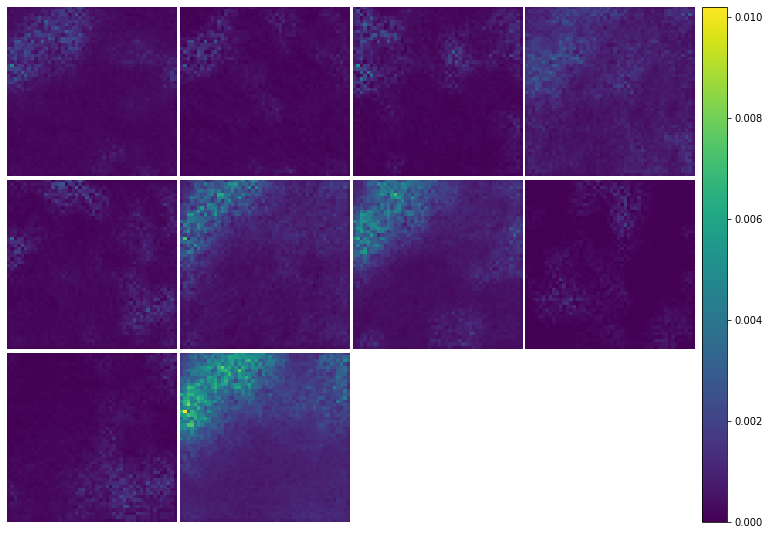

In [16]:
multiimshow(ratemaps, figsize=(10,10));